In [2]:
import pandas as pd
import pickle
import requests
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import json
import numpy as np
from numpy import cov
import csv
#извлекает функцию из другого файла ipynb
#from ipynb.fs.full.Methods import download_ats_peak_load

## Формирование фрейма для анализа алгоритма

In [4]:
df = pd.read_excel('INITIAL_DATA/Свод_Почасовая выработка 2019 и 2020 обновл.xls',sheet_name=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19], usecols="A:E", skiprows=1,nrows=750, header = None, names = ['timestamp','Solar_generation','External_grid','Total_consumption', 'PVSyst' ])

In [5]:
cdf = pd.concat(df,axis=0, join="inner", ignore_index=True, keys=None, levels=None, names=None, verify_integrity=False, copy=True)

In [14]:
cdf=cdf.dropna(subset=['timestamp', 'External_grid'])
cdf = pd.DataFrame(cdf) 
cdf.set_index('timestamp', inplace=True) # set column 'date' to index

In [15]:
cdf.tail(10)

,Solar_generation,External_grid,Total_consumption,PVSyst
timestamp,,,,
2020-12-30 15:00:00,50.768383,0.060983,44.852531,67.53140
2020-12-30 16:00:00,37.673286,9.469146,46.257954,56.33710
2020-12-30 17:00:00,7.117406,50.268410,57.385815,3.59276
2020-12-30 18:00:00,0.232571,71.247116,71.479683,0.00000
2020-12-30 19:00:00,0.000000,71.157036,71.157036,0.00000
2020-12-30 20:00:00,0.000000,72.031883,72.031883,0.00000
2020-12-30 21:00:00,0.000000,71.898674,71.898674,0.00000
2020-12-30 22:00:00,0.000000,71.619385,71.619385,0.00000
2020-12-30 23:00:00,0.000000,71.852371,71.852371,0.00000


In [16]:
cdf.describe()

,Solar_generation,External_grid,Total_consumption,PVSyst
count,13143.000000,13143.000000,13136.000000,13142.000000
mean,31.876580,156.525587,188.417357,69.952133
std,66.501208,142.678545,172.222914,100.775985
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,56.182621,58.468653,0.000000
50%,1.463306,85.453865,107.195679,0.000000
75%,26.580052,265.544342,322.942841,124.118900
max,356.581116,940.887451,1075.956665,405.421449


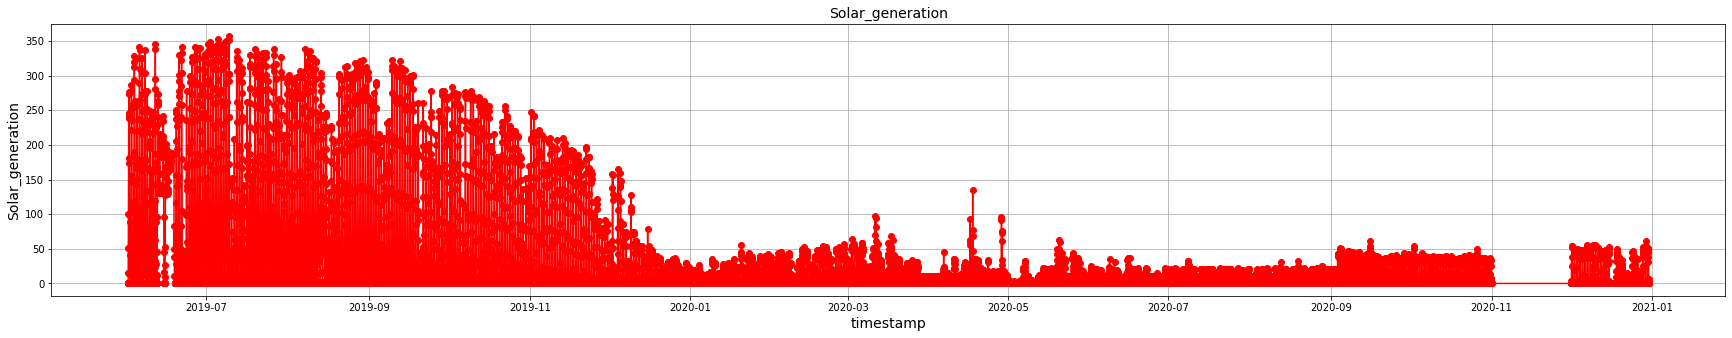

In [18]:
plt.figure(figsize=(30, 5))
plt.plot(cdf.index, cdf['Solar_generation'], color='red', marker='o')
plt.title('Solar_generation', fontsize=14)
plt.xlabel('timestamp', fontsize=14)
plt.ylabel('Solar_generation', fontsize=14)
plt.grid(True)
plt.show()